In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.distance import geodesic
from esda.moran import Moran
from libpysal.weights import Queen
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx

In [2]:
from libpysal.weights import W, full2W
import seaborn as sns
from scipy import stats

# DE Level

In [3]:
data = pd.read_csv('data.csv')
# Replace '..' with NaN
data.replace('..', np.nan, inplace=True)

# Drop rows with any NaN values
data.dropna(inplace=True)

# Display the first few rows of the cleaned data
data.head()

,country,country code,year,credit,broadband,telephone,GDPPC,tech,ict,internet,cellular,patent_nonresidents,patent_residents,patent,RD,researcher,education,urban,latitude,longitude
0,Austria,AUT,2009,97.73957467,1878524,3253000,42655.19213,13.43745371,4.012334698,73.45,11434000,292,2263,2555,2.596740007,4158.864746,67.99157715,57.683,48.210033,16.363449
1,Austria,AUT,2010,98.52832394,2050400,3398000,43334.50896,13.70527973,3.94819967,75.17,12241000,249,2424,2673,2.726099968,4380.434082,75.04025269,57.399,48.210033,16.363449
2,Austria,AUT,2011,96.06109929,2097700,3388000,44451.00019,13.25532734,3.7939034,78.7399931,13022578,276,2154,2430,2.668679953,4431.666992,77.26251221,57.115,48.210033,16.363449
3,Austria,AUT,2012,94.22379903,2130200,3380000,44549.88170,14.54464429,3.889467798,80.02999392,13588000,294,2258,2552,2.914720058,4721.936035,79.54712677,57.147,48.210033,16.363449
4,Austria,AUT,2013,92.55775212,2232500,3334000,44299.37818,15.36900841,4.206127886,80.6188,13272000,244,2162,2406,2.954920053,4783.213867,80.96160126,57.336,48.210033,16.363449


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 0 to 426
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              323 non-null    object 
 1   country code         323 non-null    object 
 2   year                 323 non-null    int64  
 3   credit               323 non-null    object 
 4   broadband            323 non-null    object 
 5   telephone            323 non-null    object 
 6   GDPPC                323 non-null    float64
 7   tech                 323 non-null    object 
 8   ict                  323 non-null    object 
 9   internet             323 non-null    object 
 10  cellular             323 non-null    object 
 11  patent_nonresidents  323 non-null    object 
 12  patent_residents     323 non-null    object 
 13  patent               323 non-null    object 
 14  RD                   323 non-null    object 
 15  researcher           323 non-null    object 


In [5]:
# Columns to be scaled
columns_to_scale = ['broadband', 'telephone', 'internet', 'cellular', 'credit', 'ict', 'tech']

In [6]:
#Standardize the data

scaler = MinMaxScaler()

data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

In [7]:
# Calculate entropy
def calculate_entropy(data):
    P = data / data.sum(axis=0)  # Calculate the probability distribution
    E = -np.nansum(P * np.log(P), axis=0) / np.log(len(data))  # entropy
    return E

# Calculate weights
def calculate_weights(entropy):
    d = 1 - entropy  # Calculate the degree of diversification
    w = d / d.sum()  # Calculate weights
    return w

# Calculate the entropy for each indicator
entropy = calculate_entropy(data[columns_to_scale])

# Calculate the weights for each indicator
weights = calculate_weights(entropy)


print("Entropy:\n", entropy)
print("Weights:\n", weights)

Entropy:
 [0.86844688 0.83082337 0.99080709 0.88288097 0.96000533 0.92744504
 0.95413373]
Weights:
 [0.22470137 0.28896479 0.0157021  0.20004699 0.06831351 0.12392864
 0.0783426 ]


/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [8]:
# Compute the comprehensive DE score
data['DE_index'] = data[columns_to_scale].dot(weights)

print(data.head())

   country country code  year    credit  broadband  telephone        GDPPC  \
0  Austria          AUT  2009  0.317835   0.048002   0.063101  42655.19213   
1  Austria          AUT  2010  0.321264   0.052676   0.066090  43334.50896   
2  Austria          AUT  2011  0.310539   0.053963   0.065884  44451.00019   
3  Austria          AUT  2012  0.302552   0.054847   0.065719  44549.88170   
4  Austria          AUT  2013  0.295310   0.057629   0.064771  44299.37818   

       tech       ict  internet  ...  patent_nonresidents patent_residents  \
0  0.194601  0.078775  0.590545  ...                  292             2263   
1  0.200837  0.077232  0.618109  ...                  249             2424   
2  0.190360  0.073521  0.675320  ...                  276             2154   
3  0.220381  0.075819  0.695993  ...                  294             2258   
4  0.239576  0.083436  0.705429  ...                  244             2162   

  patent           RD   researcher    education   urban   lati

In [9]:
# Save the results to a CSV file
data.to_csv('DE_Level.csv', index=False)

# Spatial Autocorrelation

## Weight matrix

### 1.Geographical Distance Matrix

In [10]:
# Extract the country names and coordinates
countries = data['country']
coordinates = data[['latitude', 'longitude']].values

In [11]:
# Calculate the geographical distance matrix
num_countries = len(countries)
distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            distances[i, j] = geodesic(coordinates[i], coordinates[j]).kilometers
        else:
            distances[i, j] = 0  # Distance to itself is 0

In [12]:
# Add a small value to non-diagonal zero elements to avoid infinite weights
epsilon = 1e-5
distances[distances == 0] = epsilon

# Print the geographical distance matrix
print("Geographical Distance Matrix:")
print(distances)

Geographical Distance Matrix:
[[1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 ...
 [1.24256409e+03 1.24256409e+03 1.24256409e+03 ... 1.00000000e-05
  1.54608161e+03 1.54608161e+03]
 [6.84852340e+02 6.84852340e+02 6.84852340e+02 ... 1.54608161e+03
  1.00000000e-05 1.00000000e-05]
 [6.84852340e+02 6.84852340e+02 6.84852340e+02 ... 1.54608161e+03
  1.00000000e-05 1.00000000e-05]]


In [13]:
# Construct the geographical distance weight matrix (inverse square of distances)
W1 = np.zeros_like(distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W1 = 1 / distances
    W1[distances == 0] = 0  # Set diagonal to 0 to avoid division by zero


In [14]:
# Print the geographical distance weight matrix
print("Geographical Distance Weight Matrix:")
print(W1)

Geographical Distance Weight Matrix:
[[1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 ...
 [8.04787459e-04 8.04787459e-04 8.04787459e-04 ... 1.00000000e+05
  6.46796386e-04 6.46796386e-04]
 [1.46016877e-03 1.46016877e-03 1.46016877e-03 ... 6.46796386e-04
  1.00000000e+05 1.00000000e+05]
 [1.46016877e-03 1.46016877e-03 1.46016877e-03 ... 6.46796386e-04
  1.00000000e+05 1.00000000e+05]]


In [15]:
# Save the weight matrix to a CSV file for later use
#np.savetxt('geographical_distance_weight_matrix.csv', W1, delimiter=',')

In [16]:
#distance_matrix.csv', distances, delimiter=',')

### 2.Economic Distance Matrix

In [17]:
# Extract the country names and GDP per capita
countries = data['country']
gdp_per_capita = data['GDPPC'].values

# Calculate the economic distance matrix
num_countries = len(countries)
economic_distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            economic_distances[i, j] = abs(gdp_per_capita[i] - gdp_per_capita[j])
        else:
            economic_distances[i, j] = 0  # Distance to itself is 0

# Print the economic distance matrix
print("Economic Distance Matrix:")
print(economic_distances)

Economic Distance Matrix:
[[    0.        679.31683  1795.80806 ... 12160.81372 39309.69429
  41151.25547]
 [  679.31683     0.       1116.49123 ... 11481.49689 38630.37746
  40471.93864]
 [ 1795.80806  1116.49123     0.      ... 10365.00566 37513.88623
  39355.44741]
 ...
 [12160.81372 11481.49689 10365.00566 ...     0.      27148.88057
  28990.44175]
 [39309.69429 38630.37746 37513.88623 ... 27148.88057     0.
   1841.56118]
 [41151.25547 40471.93864 39355.44741 ... 28990.44175  1841.56118
      0.     ]]


In [18]:
# Construct the economic distance weight matrix (inverse of economic distances)
W2 = np.zeros_like(economic_distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W2 = 1 / economic_distances
    W2[economic_distances == 0] = 0  # Set diagonal to 0 to avoid division by zero

# Print the economic distance weight matrix
print("Economic Distance Weight Matrix:")
print(W2)

Economic Distance Weight Matrix:
[[0.00000000e+00 1.47206716e-03 5.56852384e-04 ... 8.22313394e-05
  2.54390175e-05 2.43005952e-05]
 [1.47206716e-03 0.00000000e+00 8.95663103e-04 ... 8.70966573e-05
  2.58863637e-05 2.47084779e-05]
 [5.56852384e-04 8.95663103e-04 0.00000000e+00 ... 9.64784808e-05
  2.66567957e-05 2.54094431e-05]
 ...
 [8.22313394e-05 8.70966573e-05 9.64784808e-05 ... 0.00000000e+00
  3.68339312e-05 3.44941277e-05]
 [2.54390175e-05 2.58863637e-05 2.66567957e-05 ... 3.68339312e-05
  0.00000000e+00 5.43017528e-04]
 [2.43005952e-05 2.47084779e-05 2.54094431e-05 ... 3.44941277e-05
  5.43017528e-04 0.00000000e+00]]


### Economic-Geographical Matrix

In [19]:
W3 = W1 * W2

In [20]:
# Calculate Moran's I using the economic-geographical weight matrix
# Convert the economic-geographical weight matrix to a pysal weights object
w3 = full2W(W3)

moran = Moran(data['DE_index'], w3)

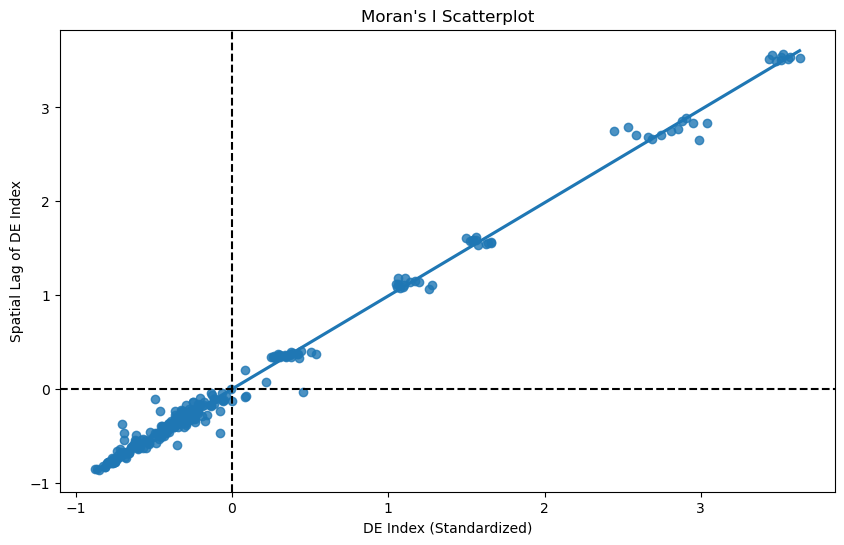

In [21]:
# Manually create the Moran scatter plot
z = (data['DE_index'] - data['DE_index'].mean()) / data['DE_index'].std()
wz = w3.sparse @ z

plt.figure(figsize=(10, 6))
sns.regplot(x=z, y=wz, ci=None)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.title("Moran's I Scatterplot")
plt.xlabel("DE Index (Standardized)")
plt.ylabel("Spatial Lag of DE Index")
plt.show()


In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot


/tmp/ipykernel_52497/606818346.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f49c3cc1c10>

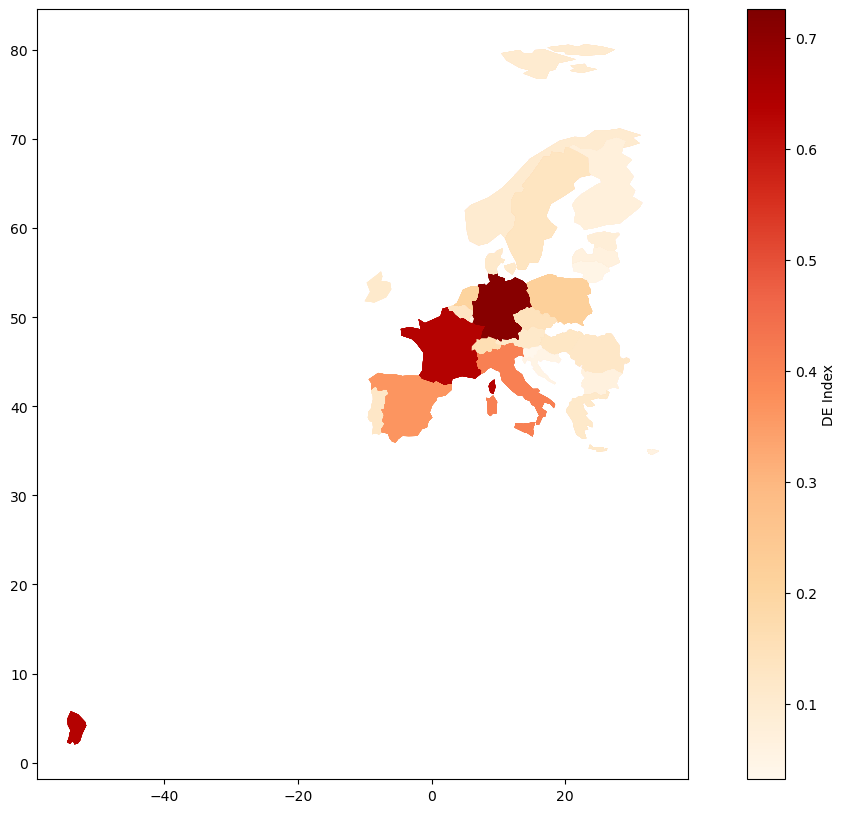

In [23]:
# Visualize the countries on a map
# Assuming 'geometry' column in data contains the geometry of each country
# If not, you need to merge with a world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name.isin(countries)]
world = world.merge(data, left_on='name', right_on='country')

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(world, geometry='geometry')

# Plot the countries with DE index
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='DE_index', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "DE Index"})
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.title('Digital Economy Index by Country')
plt.show()


In [ ]:
# 读取欧洲地图的地理数据
# 使用Natural Earth数据集
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 过滤出欧洲国家
europe = world[world['continent'] == 'Europe']

# 检查数据中国家名称与地理数据中的名称是否一致
print(europe[['name']])

# 获取所有年份
years = data['year'].unique()

# 创建子图
fig, axs = plt.subplots(1, len(years), figsize=(20, 10), constrained_layout=True)

for i, year in enumerate(years):
    # 过滤出特定年份的数据
    data_year = data[data['year'] == year]
    
    # 合并数据
    data_year.rename(columns={'country': 'name'}, inplace=True)
    europe_year = europe.merge(data_year, on='name')
    
    # 创建一个GeoDataFrame
    gdf = gpd.GeoDataFrame(europe_year, geometry='geometry')
    
    # 绘制地图
    gdf.plot(column='DE_index', ax=axs[i], legend=True, cmap='OrRd',
             legend_kwds={'label': "DE Index"})
    ctx.add_basemap(axs[i], source=ctx.providers.Stamen.TonerLite, zoom=4)
    axs[i].set_title(f'DE Index in {year}')
    axs[i].axis('off')

plt.suptitle('Digital Economy Index by Country in Europe Over the Years')
plt.show()

# Innovation Efficiency

## Stochastic Frontier Analysis

In [24]:
import statsmodels.api as sm

In [33]:
# 转换数据类型为浮点数，并处理无法转换的值
data['patent'] = pd.to_numeric(data['patent'], errors='coerce')
data['RD'] = pd.to_numeric(data['RD'], errors='coerce')
data['researcher'] = pd.to_numeric(data['researcher'], errors='coerce')

# 查看转换后的数据类型
print(data.dtypes)

country                 object
country code            object
year                     int64
credit                 float64
broadband              float64
telephone              float64
GDPPC                  float64
tech                   float64
ict                    float64
internet               float64
cellular               float64
patent_nonresidents     object
patent_residents        object
patent                   int64
RD                     float64
researcher             float64
education               object
urban                  float64
latitude               float64
longitude              float64
DE_index               float64
dtype: object


In [34]:
data['ln_patent'] = np.log(data['patent'])
data['ln_RD'] = np.log(data['RD'])
data['ln_researcher'] = np.log(data['researcher'])

In [35]:
# 查看预处理后的数据
print(data[['ln_patent', 'ln_RD', 'ln_researcher']].head())

   ln_patent     ln_RD  ln_researcher
0   7.845808  0.954257       8.332997
1   7.890957  1.002872       8.384903
2   7.795647  0.981584       8.396531
3   7.844633  1.069774       8.459974
4   7.785721  1.083472       8.472868


In [36]:
# 设置自变量和因变量
X = data[['ln_RD', 'ln_researcher']]
y = data['ln_patent']

# 添加常数项
X = sm.add_constant(X)

# 拟合普通最小二乘法（OLS）模型
ols_model = sm.OLS(y, X).fit()

# 输出模型结果
print(ols_model.summary())

# 残差即为u + v
residuals = ols_model.resid

# 这里假设v服从正态分布，u服从正态分布的截断分布
# 使用最大似然估计来分离u和v，计算技术效率
# 我们将使用一个简单的截断正态分布的MLE估计

def log_likelihood(params):
    sigma_v, sigma_u = params
    n = len(residuals)
    ll = -n * np.log(sigma_v) - n * np.log(sigma_u) - np.sum((residuals / (sigma_v + sigma_u))**2)
    return -ll

from scipy.optimize import minimize

result = minimize(log_likelihood, [1, 1], bounds=((1e-6, None), (1e-6, None)))
sigma_v, sigma_u = result.x

# 计算技术效率
data['Efficiency'] = np.exp(-residuals / sigma_u)

# 查看带有效率得分的数据
print(data[['patent', 'RD', 'researcher', 'Efficiency']])


                            OLS Regression Results                            
Dep. Variable:              ln_patent   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     96.71
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.40e-33
Time:                        14:44:35   Log-Likelihood:                -601.95
No. Observations:                 323   AIC:                             1210.
Df Residuals:                     320   BIC:                             1221.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.0132      2.745      7.291